In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import requests
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [ ]:
#import data from csv file
df1 = pd.read_csv('S&P BSE Teck Historical Data.csv')

In [ ]:
# API details (replace with actual values)
api_url = "https://api.mfapi.in/mf/120594"
api_params = {"scheme_code": 120594}  # Assuming scheme_code is the required parameter

# Make the API request
response = requests.get(api_url, params=api_params)
data = response.json()

# Create a DataFrame
df = pd.DataFrame(data["data"])  # Extract the "data" list from the response

# Add calculated column (replace with your calculation logic)
#df["calculated_column"] = df["nav"] * 1.1  # Example: increase NAV by 10%

# Save to CSV
#df.to_csv("fund_data.csv", index=False)


In [ ]:
# Rename the column first
df1.rename(columns={"Date": "date"}, inplace=True)

# Now convert the date format
df1["date"] = pd.to_datetime(df1["date"], format='%m/%d/%Y').dt.strftime("%d-%m-%Y")

In [ ]:
print(df1.head())

         date      Price       Open       High        Low    Vol. Change %
0  20-01-2024  16,616.35  16,840.91  16,848.41  16,604.55     NaN   -0.87%
1  19-01-2024  16,762.62  16,673.91  16,779.41  16,673.79  59.58K    1.29%
2  18-01-2024  16,548.78  16,517.33  16,574.08  16,344.10  50.58K   -0.19%
3  17-01-2024  16,580.51  16,424.69  16,656.80  16,390.26  75.05K    0.22%
4  16-01-2024  16,544.56  16,740.20  16,740.20  16,501.08  73.74K   -1.12%


In [ ]:
print(df1['date'].duplicated().sum())
print(df['date'].duplicated().sum())
print(df1['date'].isna().sum())
print(df['date'].isna().sum())
print(len(df1))
print(len(df))

0
0
0
0
2736
2756


In [ ]:
#keep only the dates in df1 that are in df
df1 = df1[df1['date'].isin(df['date'])]
print(len(df1))

2719


In [ ]:
print(df1.head())
print(df.head())
print(df1.tail())
print(df.tail())

         date      Price       Open       High        Low    Vol. Change %
1  19-01-2024  16,762.62  16,673.91  16,779.41  16,673.79  59.58K    1.29%
2  18-01-2024  16,548.78  16,517.33  16,574.08  16,344.10  50.58K   -0.19%
3  17-01-2024  16,580.51  16,424.69  16,656.80  16,390.26  75.05K    0.22%
4  16-01-2024  16,544.56  16,740.20  16,740.20  16,501.08  73.74K   -1.12%
5  15-01-2024  16,732.45  16,713.90  16,893.24  16,649.81  64.14K    1.79%
         date        nav
0  15-03-2024  196.85000
1  14-03-2024  197.28000
2  13-03-2024  192.92000
3  12-03-2024  196.04000
4  11-03-2024  195.24000
            date     Price      Open      High       Low    Vol. Change %
2731  08-01-2013  3,514.39  3,516.38  3,522.73  3,495.37   8.36K   -0.14%
2732  07-01-2013  3,519.49  3,524.77  3,537.07  3,514.18  10.46K    0.13%
2733  04-01-2013  3,514.91  3,502.28  3,517.65  3,498.69   8.84K    0.68%
2734  03-01-2013  3,491.06  3,453.27  3,496.87  3,448.30  12.69K    1.32%
2735  02-01-2013  3,445.46  3,

In [ ]:
df1["Change %"] = df1["Change %"].str.replace("%", "")
#do it for each column except date
df1["Price"] = df1["Price"].str.replace(",", "")
df1["Open"] = df1["Open"].str.replace(",", "")
df1["High"] = df1["High"].str.replace(",", "")
df1["Low"] = df1["Low"].str.replace(",", "")
numeric_columns = df1.columns.difference(["date", "Vol."])

In [ ]:
#convert Vol. to numeric and replace the values in the same column
#if K then multiply by 1000, if M then multiply by 1000000, if B then multiply by 1000000000
#create a function to do this
def adjust_volume(value):
    if pd.isna(value):
        return value  # Keep NaN as is

    if value.endswith("M"):
        return pd.to_numeric(value[:-1]) * 1000000
    elif value.endswith("B"):
        return pd.to_numeric(value[:-1]) * 1000000000
    elif value.endswith("K"):
        return pd.to_numeric(value[:-1]) * 1000
    else:
        return pd.to_numeric(value)  # No modifier, assume original value
df1['Vol.'] = df1['Vol.'].apply(adjust_volume)



In [ ]:
nan_count = df1['Vol.'].isna().sum()
print(nan_count)

3


In [ ]:
nan_indices = df1[df1['Vol.'].isna()].index
print(nan_indices)

Int64Index([108, 206, 356], dtype='int64')


In [ ]:
df1['Vol.'] = df1['Vol.'].interpolate()

In [ ]:
nan_count = df1['Vol.'].isna().sum()
print(nan_count)

0


In [ ]:
print(df1.dtypes)

date         object
Price        object
Open         object
High         object
Low          object
Vol.        float64
Change %     object
dtype: object


In [ ]:

#df1.dtypes
df1[numeric_columns] = df1[numeric_columns].apply(pd.to_numeric)
#df1[numeric_columns] = df1[numeric_columns].astype(float64)
df["nav"] = df["nav"].apply(pd.to_numeric)


In [ ]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29411 sha256=8b2cc82a9b3ac7be45b075d5d8de023abfb3b591eb9b776e98e18d1c8076e21f
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [ ]:
import ta

# Assuming your df1 index data is in a DataFrame 'df1'
df1['RSI'] = ta.momentum.rsi(df1['Price'], window=14)
macd = ta.trend.macd_diff(df1['Price'])
df1['MACD'] = macd
macd_signal = ta.trend.macd_signal(df1['Price'])
df1['MACD_Signal'] = macd_signal
bandwidth = 2
indicator_bb = ta.volatility.BollingerBands(close=df1['Price'], window=20, window_dev=2)
df1['BB_Upper'] = indicator_bb.bollinger_hband()
df1['BB_Middle'] = indicator_bb.bollinger_mavg()
df1['BB_Lower'] = indicator_bb.bollinger_lband()

In [ ]:
#clean the new columns
print(df1['BB_Upper'].isna().sum())
print(df1['BB_Lower'].isna().sum())
print(df1['BB_Middle'].isna().sum())
print(df1['RSI'].isna().sum())
print(df1['MACD'].isna().sum())
print(df1['MACD_Signal'].isna().sum())

19
19
19
13
33
33


In [ ]:
# drop 33 rows
df1 = df1.iloc[33:]
print(df1.dtypes)

date            object
Price          float64
Open           float64
High           float64
Low            float64
Vol.           float64
Change %       float64
RSI            float64
MACD           float64
MACD_Signal    float64
BB_Upper       float64
BB_Middle      float64
BB_Lower       float64
dtype: object


In [ ]:
#check the new columns again
print(df1['BB_Upper'].isna().sum())
print(df1['BB_Lower'].isna().sum())
print(df1['BB_Middle'].isna().sum())
print(df1['RSI'].isna().sum())
print(df1['MACD'].isna().sum())
print(df1['MACD_Signal'].isna().sum())

0
0
0
0
0
0


In [ ]:
merged_data = df.merge(df1, on="date")
print(merged_data.head())
print(merged_data.dtypes)

         date     nav     Price      Open      High       Low        Vol.  \
0  01-12-2023  174.48  14890.24  14921.13  14931.48  14847.56  48670000.0   
1  30-11-2023  174.21  14874.19  14857.41  14889.59  14787.85     79170.0   
2  29-11-2023  173.90  14848.74  14736.52  14864.09  14736.52     35920.0   
3  28-11-2023  171.94  14673.05  14634.62  14696.99  14537.57     38830.0   
4  24-11-2023  171.58  14613.33  14703.89  14761.37  14602.71     29600.0   

   Change %        RSI       MACD  MACD_Signal      BB_Upper   BB_Middle  \
0      0.11  30.864744 -33.562583  -296.476613  16356.646893  15496.5995   
1      0.17  30.578187 -27.852446  -303.439724  16311.566547  15441.1690   
2      1.20  30.100959 -21.671128  -308.857506  16262.215143  15386.7000   
3      0.41  26.971538 -25.057092  -315.121779  16201.222521  15320.4055   
4     -0.89  25.982699 -26.804101  -321.822805  16131.010939  15252.3890   

       BB_Lower  
0  14636.552107  
1  14570.771453  
2  14511.184857  
3  14439

In [ ]:
#clean the new columns
print(merged_data['BB_Upper'].isna().sum())
print(merged_data['BB_Lower'].isna().sum())
print(merged_data['BB_Middle'].isna().sum())
print(merged_data['RSI'].isna().sum())
print(merged_data['MACD'].isna().sum())
print(merged_data['MACD_Signal'].isna().sum())

0
0
0
0
0
0


In [ ]:
risk_free_rate = 0.07

# Calculate the returns for the mutual fund and benchmark index
merged_data['Fund_Return'] = (merged_data['Price'] - merged_data['nav']) / merged_data['nav']
merged_data['Index_Return'] = merged_data['Change %'] / 100  # Assuming change% is in percentage

# Calculate the beta value (covariance/variance)
covariance_matrix = merged_data[['Fund_Return', 'Index_Return']].cov()
beta = covariance_matrix.loc['Fund_Return', 'Index_Return'] / covariance_matrix.loc['Index_Return', 'Index_Return']

# Calculate the expected return of the mutual fund using CAPM
merged_data['Expected_Fund_Return'] = risk_free_rate + beta * (merged_data['Index_Return'] - risk_free_rate)

# Calculate alpha value
merged_data['Alpha'] = merged_data['Fund_Return'] - merged_data['Expected_Fund_Return']

# Display the dataframe with alpha values
print(merged_data[['nav', 'Price', 'Index_Return', 'Expected_Fund_Return', 'Fund_Return', 'Alpha']])

         nav     Price  Index_Return  Expected_Fund_Return  Fund_Return  \
0     174.48  14890.24        0.0011             -2.371446    84.340669   
1     174.21  14874.19        0.0017             -2.350185    84.380805   
2     173.90  14848.74        0.0120             -1.985208    84.386659   
3     171.94  14673.05        0.0041             -2.265142    84.338199   
4     171.58  14613.33       -0.0089             -2.725792    84.169192   
...      ...       ...           ...                   ...          ...   
2681   19.71   3514.39       -0.0014             -2.460032   177.304921   
2682   19.70   3519.49        0.0013             -2.364359   177.654315   
2683   19.74   3514.91        0.0068             -2.169468   177.060284   
2684   19.68   3491.06        0.0132             -1.942687   176.391260   
2685   19.47   3445.46        0.0020             -2.339555   175.962506   

           Alpha  
0      86.712115  
1      86.730990  
2      86.371867  
3      86.603341  
4   

In [ ]:
print(merged_data.dtypes)

date                     object
nav                     float64
Price                   float64
Open                    float64
High                    float64
Low                     float64
Vol.                    float64
Change %                float64
RSI                     float64
MACD                    float64
MACD_Signal             float64
BB_Upper                float64
BB_Middle               float64
BB_Lower                float64
Fund_Return             float64
Index_Return            float64
Expected_Fund_Return    float64
Alpha                   float64
dtype: object


In [ ]:
from sklearn.feature_selection import mutual_info_regression
X = merged_data.drop(['nav','date'], axis=1)
y = merged_data['nav']
columns_with_nan = X.columns[X.isna().any()].tolist()
print(columns_with_nan)

[]


In [ ]:
mutual_info = mutual_info_regression(X, y)
mutual_info = pd.Series(mutual_info, index=X.columns)
mutual_info.sort_values(ascending=False, inplace=True)
print(mutual_info)

Price                   2.943608
Low                     2.805943
High                    2.781335
Open                    2.629349
BB_Middle               2.616825
BB_Lower                2.573160
BB_Upper                2.553090
Fund_Return             2.256741
Alpha                   2.228254
MACD_Signal             0.839573
Vol.                    0.621926
MACD                    0.287428
RSI                     0.262161
Change %                0.000000
Index_Return            0.000000
Expected_Fund_Return    0.000000
dtype: float64


In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor()
rf_model.fit(X, y)
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importances_sorted = feature_importances.sort_values(ascending=False)
print("\nFeature Importance from Random Forest:")
print(feature_importances_sorted)


Feature Importance from Random Forest:
Low                     0.348331
Price                   0.279864
BB_Middle               0.183194
BB_Upper                0.097792
BB_Lower                0.027095
Open                    0.023290
High                    0.018952
Fund_Return             0.014509
Alpha                   0.006762
MACD_Signal             0.000088
RSI                     0.000054
MACD                    0.000033
Vol.                    0.000021
Change %                0.000006
Index_Return            0.000004
Expected_Fund_Return    0.000004
dtype: float64


In [ ]:
#dropping the unecessary columns
merged_data = merged_data.drop(['Change %','Index_Return','Expected_Fund_Return','MACD','MACD_Signal','Vol.'], axis=1)

In [ ]:
print(merged_data.dtypes)
print(merged_data.shape)

date            object
nav            float64
Price          float64
Open           float64
High           float64
Low            float64
RSI            float64
BB_Upper       float64
BB_Middle      float64
BB_Lower       float64
Fund_Return    float64
Alpha          float64
dtype: object
(2686, 12)


In [ ]:
# Convert 'date' column to datetime index
merged_data['date'] = pd.to_datetime(merged_data['date'])
merged_data.set_index('date', inplace=True)

# Separate features (X) and target variable (y)
X = merged_data.drop(['nav'], axis=1)
y = merged_data['nav'].values.reshape(-1, 1)

# Split the data into train and test sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scale the features using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define a function to reshape data for LSTM input
def reshape_data(X, time_steps):
    X_reshaped = []
    for i in range(len(X) - time_steps):
        X_reshaped.append(X[i:(i + time_steps)])
    return np.array(X_reshaped)

# Define the number of time steps
time_steps = 14  # You can adjust this value based on the temporal dependencies in your data

# Reshape the data for LSTM input
X_train_reshaped = reshape_data(X_train_scaled, time_steps)
X_test_reshaped = reshape_data(X_test_scaled, time_steps)
y_train_reshaped = y_train[time_steps:]
y_test_reshaped = y_test[time_steps:]


<ipython-input-31-d61bca4b7d19>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  merged_data['date'] = pd.to_datetime(merged_data['date'])


In [ ]:
# Define the LSTM model architecture
model = Sequential([
    LSTM(units=64, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(units=64, return_sequences=False),
    Dropout(0.2),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_reshaped, y_train_reshaped, epochs=85, batch_size=32, validation_split=0.1)

# Evaluate the model on the test set
y_pred = model.predict(X_test_reshaped)
mae = mean_absolute_error(y_test_reshaped, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_reshaped, y_pred))
print("Mean Absolute Error on Test Set:", mae)
print("Root Mean Squared Error on Test Set:", rmse)


Epoch 1/85
60/60 [==============================] - 8s 39ms/step - loss: 8888.9150 - val_loss: 785.0771
Epoch 2/85
60/60 [==============================] - 1s 16ms/step - loss: 7783.0332 - val_loss: 563.8185
Epoch 3/85
60/60 [==============================] - 1s 17ms/step - loss: 7200.4878 - val_loss: 396.3387
Epoch 4/85
60/60 [==============================] - 1s 19ms/step - loss: 6694.5225 - val_loss: 264.6162
Epoch 5/85
60/60 [==============================] - 1s 18ms/step - loss: 6229.2725 - val_loss: 162.9884
Epoch 6/85
60/60 [==============================] - 1s 16ms/step - loss: 5820.3433 - val_loss: 89.4269
Epoch 7/85
60/60 [==============================] - 1s 18ms/step - loss: 5448.3281 - val_loss: 38.7490
Epoch 8/85
60/60 [==============================] - 1s 19ms/step - loss: 5094.0654 - val_loss: 10.7150
Epoch 9/85
60/60 [==============================] - 1s 21ms/step - loss: 4788.4688 - val_loss: 2.0587
Epoch 10/85
60/60 [==============================] - 2s 29ms/step - l

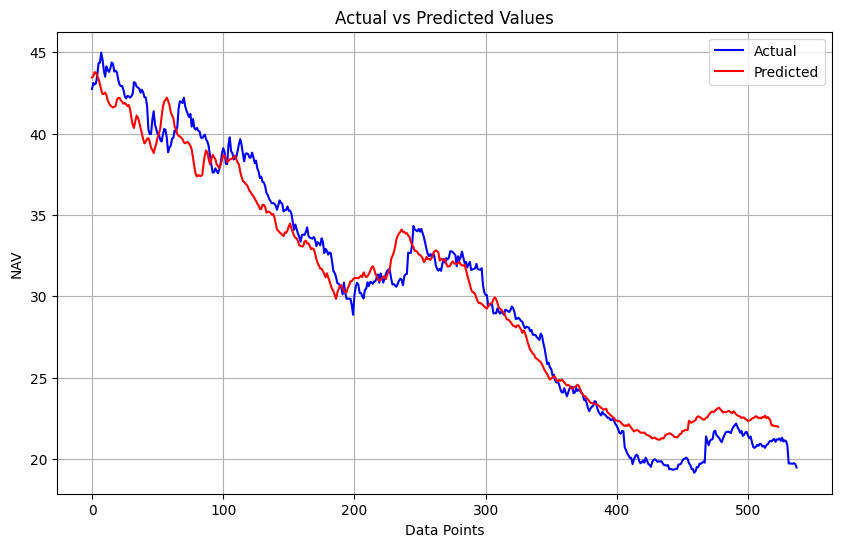

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'y_test' contains the actual target values and 'y_pred' contains the predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red')
plt.title('Actual vs Predicted Values')
plt.xlabel('Data Points')
plt.ylabel('NAV')
plt.legend()
plt.grid(True)
plt.show()
